In [ ]:
# Co-occurence matrix

In [2]:
import logging
import random
import warnings
import tempfile
import os
from subprocess import PIPE
import numpy as np

from gensim import utils, corpora, matutils
from gensim.utils import check_output

logger = logging.getLogger(__name__)


class DtmModel(utils.SaveLoad):
    """Python wrapper using `DTM implementation <https://github.com/magsilva/dtm/tree/master/bin>`_.

    Communication between DTM and Python takes place by passing around data files on disk and executing
    the DTM binary as a subprocess.

    Warnings
    --------
    This is **only** python wrapper for `DTM implementation <https://github.com/magsilva/dtm/tree/master/bin>`_,
    you need to install original implementation first and pass the path to binary to ``dtm_path``.

    """
    def __init__(self, dtm_path, corpus=None, time_slices=None, mode='fit', model='dtm', num_topics=100,
                 id2word=None, prefix=None, lda_sequence_min_iter=6, lda_sequence_max_iter=20, lda_max_em_iter=10,
                 alpha=0.01, top_chain_var=0.005, rng_seed=0, initialize_lda=True):
        """

        Parameters
        ----------
        dtm_path : str
            Path to the dtm binary, e.g. `/home/username/dtm/dtm/main`.
        corpus : iterable of iterable of (int, int)
            Collection of texts in BoW format.
        time_slices : list of int
            Sequence of timestamps.
        mode : {'fit', 'time'}, optional
            Controls the mode of the mode: 'fit' is for training, 'time' for analyzing documents through time
            according to a DTM, basically a held out set.
        model : {'fixed', 'dtm'}, optional
            Control model that will be runned: 'fixed' is for DIM and 'dtm' for DTM.
        num_topics : int, optional
            Number of topics.
        id2word : :class:`~gensim.corpora.dictionary.Dictionary`, optional
            Mapping between tokens ids and words from corpus, if not specified - will be inferred from `corpus`.
        prefix : str, optional
            Prefix for produced temporary files.
        lda_sequence_min_iter : int, optional
             Min iteration of LDA.
        lda_sequence_max_iter : int, optional
            Max iteration of LDA.
        lda_max_em_iter : int, optional
             Max em optimization iterations in LDA.
        alpha : int, optional
            Hyperparameter that affects sparsity of the document-topics for the LDA models in each timeslice.
        top_chain_var : float, optional
            This hyperparameter controls one of the key aspect of topic evolution which is the speed at which
            these topics evolve. A smaller top_chain_var leads to similar word distributions over multiple timeslice.

        rng_seed : int, optional
             Random seed.
        initialize_lda : bool, optional
             If True - initialize DTM with LDA.

        """
        if not os.path.isfile(dtm_path):
            raise ValueError("dtm_path must point to the binary file, not to a folder")

        self.dtm_path = dtm_path
        self.id2word = id2word
        if self.id2word is None:
            logger.warning("no word id mapping provided; initializing from corpus, assuming identity")
            self.id2word = utils.dict_from_corpus(corpus)
            self.num_terms = len(self.id2word)
        else:
            self.num_terms = 0 if not self.id2word else 1 + max(self.id2word.keys())
        if self.num_terms == 0:
            raise ValueError("cannot compute DTM over an empty collection (no terms)")
        self.num_topics = num_topics

        try:
            lencorpus = len(corpus)
        except TypeError:
            logger.warning("input corpus stream has no len(); counting documents")
            lencorpus = sum(1 for _ in corpus)
        if lencorpus == 0:
            raise ValueError("cannot compute DTM over an empty corpus")
        if model == "fixed" and any(not text for text in corpus):
            raise ValueError("""There is a text without words in the input corpus.
                    This breaks method='fixed' (The DIM model).""")
        if lencorpus != sum(time_slices):
            raise ValueError(
                "mismatched timeslices %{slices} for corpus of len {clen}"
                .format(slices=sum(time_slices), clen=lencorpus)
            )
        self.lencorpus = lencorpus
        if prefix is None:
            rand_prefix = hex(random.randint(0, 0xffffff))[2:] + '_'
            prefix = os.path.join(tempfile.gettempdir(), rand_prefix)

        self.prefix = prefix
        self.time_slices = time_slices
        self.lda_sequence_min_iter = int(lda_sequence_min_iter)
        self.lda_sequence_max_iter = int(lda_sequence_max_iter)
        self.lda_max_em_iter = int(lda_max_em_iter)
        self.alpha = alpha
        self.top_chain_var = top_chain_var
        self.rng_seed = rng_seed
        self.initialize_lda = str(initialize_lda).lower()

        self.lambda_ = None
        self.obs_ = None
        self.lhood_ = None
        self.gamma_ = None
        self.init_alpha = None
        self.init_beta = None
        self.init_ss = None
        self.em_steps = []
        self.influences_time = []

        if corpus is not None:
            self.train(corpus, time_slices, mode, model)

    def fout_liklihoods(self):
        """Get path to temporary lhood data file.

        Returns
        -------
        str
            Path to lhood data file.

        """
        return self.prefix + 'train_out/lda-seq/' + 'lhoods.dat'

    def fout_gamma(self):
        """Get path to temporary gamma data file.

        Returns
        -------
        str
            Path to gamma data file.

        """
        return self.prefix + 'train_out/lda-seq/' + 'gam.dat'

    def fout_prob(self):
        """Get template of path to temporary file.

        Returns
        -------
        str
            Path to file.

        """
        return self.prefix + 'train_out/lda-seq/' + 'topic-{i}-var-e-log-prob.dat'

    def fout_observations(self):
        """Get template of path to temporary file.

        Returns
        -------
        str
            Path to file.

        """
        return self.prefix + 'train_out/lda-seq/' + 'topic-{i}-var-obs.dat'

    def fout_influence(self):
        """Get template of path to temporary file.

        Returns
        -------
        str
            Path to file.

        """
        return self.prefix + 'train_out/lda-seq/' + 'influence_time-{i}'

    def foutname(self):
        """Get path to temporary file.

        Returns
        -------
        str
            Path to file.

        """
        return self.prefix + 'train_out'

    def fem_steps(self):
        """Get path to temporary em_step data file.

        Returns
        -------
        str
            Path to em_step data file.

        """
        return self.prefix + 'train_out/' + 'em_log.dat'

    def finit_alpha(self):
        """Get path to initially trained lda alpha file.

        Returns
        -------
        str
            Path to initially trained lda alpha file.

        """
        return self.prefix + 'train_out/' + 'initial-lda.alpha'

    def finit_beta(self):
        """Get path to initially trained lda beta file.

        Returns
        -------
        str
            Path to initially trained lda beta file.

        """
        return self.prefix + 'train_out/' + 'initial-lda.beta'

    def flda_ss(self):
        """Get path to initial lda binary file.

        Returns
        -------
        str
            Path to initial lda binary file.

        """
        return self.prefix + 'train_out/' + 'initial-lda-ss.dat'

    def fcorpustxt(self):
        """Get path to temporary file.

        Returns
        -------
        str
            Path to multiple train binary file.

        """
        return self.prefix + 'train-mult.dat'

    def fcorpus(self):
        """Get path to corpus file.

        Returns
        -------
        str
            Path to corpus file.

        """
        return self.prefix + 'train'

    def ftimeslices(self):
        """Get path to time slices binary file.

        Returns
        -------
        str
            Path to time slices binary file.

        """
        return self.prefix + 'train-seq.dat'

    def convert_input(self, corpus, time_slices):
        """Convert corpus into LDA-C format by :class:`~gensim.corpora.bleicorpus.BleiCorpus` and save to temp file.
        Path to temporary file produced by :meth:`~gensim.models.wrappers.dtmmodel.DtmModel.ftimeslices`.

        Parameters
        ----------
        corpus : iterable of iterable of (int, float)
            Corpus in BoW format.
        time_slices : list of int
            Sequence of timestamps.

        """
        logger.info("serializing temporary corpus to %s", self.fcorpustxt())
        # write out the corpus in a file format that DTM understands:
        corpora.BleiCorpus.save_corpus(self.fcorpustxt(), corpus)

        with utils.open(self.ftimeslices(), 'wb') as fout:
            fout.write(utils.to_utf8(str(len(self.time_slices)) + "\n"))
            for sl in time_slices:
                fout.write(utils.to_utf8(str(sl) + "\n"))

    def train(self, corpus, time_slices, mode, model):
        """Train DTM model.

        Parameters
        ----------
        corpus : iterable of iterable of (int, int)
            Collection of texts in BoW format.
        time_slices : list of int
            Sequence of timestamps.
        mode : {'fit', 'time'}, optional
            Controls the mode of the mode: 'fit' is for training, 'time' for analyzing documents through time
            according to a DTM, basically a held out set.
        model : {'fixed', 'dtm'}, optional
            Control model that will be runned: 'fixed' is for DIM and 'dtm' for DTM.

        """
        self.convert_input(corpus, time_slices)

        arguments = \
            "--ntopics={p0} --model={mofrl}  --mode={p1} --initialize_lda={p2} --corpus_prefix={p3} " \
            "--outname={p4} --alpha={p5}".format(
                p0=self.num_topics, mofrl=model, p1=mode, p2=self.initialize_lda,
                p3=self.fcorpus(), p4=self.foutname(), p5=self.alpha
            )

        params = \
            "--lda_max_em_iter={p0} --lda_sequence_min_iter={p1}  --lda_sequence_max_iter={p2} " \
            "--top_chain_var={p3} --rng_seed={p4} ".format(
                p0=self.lda_max_em_iter, p1=self.lda_sequence_min_iter, p2=self.lda_sequence_max_iter,
                p3=self.top_chain_var, p4=self.rng_seed
            )

        arguments = arguments + " " + params
        logger.info("training DTM with args %s", arguments)

        cmd = [self.dtm_path] + arguments.split()
        logger.info("Running command %s", cmd)
        check_output(args=cmd, stderr=PIPE)

        self.em_steps = np.loadtxt(self.fem_steps())
        self.init_ss = np.loadtxt(self.flda_ss())

        if self.initialize_lda:
            self.init_alpha = np.loadtxt(self.finit_alpha())
            self.init_beta = np.loadtxt(self.finit_beta())

        self.lhood_ = np.loadtxt(self.fout_liklihoods())

        # document-topic proportions
        self.gamma_ = np.loadtxt(self.fout_gamma())
        # cast to correct shape, gamme[5,10] is the proprtion of the 10th topic
        # in doc 5
        self.gamma_.shape = (self.lencorpus, self.num_topics)
        # normalize proportions
        self.gamma_ /= self.gamma_.sum(axis=1)[:, np.newaxis]

        self.lambda_ = np.zeros((self.num_topics, self.num_terms * len(self.time_slices)))
        self.obs_ = np.zeros((self.num_topics, self.num_terms * len(self.time_slices)))

        for t in range(self.num_topics):
            topic = "%03d" % t
            self.lambda_[t, :] = np.loadtxt(self.fout_prob().format(i=topic))
            self.obs_[t, :] = np.loadtxt(self.fout_observations().format(i=topic))
        # cast to correct shape, lambda[5,10,0] is the proportion of the 10th
        # topic in doc 5 at time 0
        self.lambda_.shape = (self.num_topics, self.num_terms, len(self.time_slices))
        self.obs_.shape = (self.num_topics, self.num_terms, len(self.time_slices))
        # extract document influence on topics for each time slice
        # influences_time[0] , influences at time 0
        if model == 'fixed':
            for k, t in enumerate(self.time_slices):
                stamp = "%03d" % k
                influence = np.loadtxt(self.fout_influence().format(i=stamp))
                influence.shape = (t, self.num_topics)
                # influence[2,5] influence of document 2 on topic 5
                self.influences_time.append(influence)

    def print_topics(self, num_topics=10, times=5, num_words=10):
        """Alias for :meth:`~gensim.models.wrappers.dtmmodel.DtmModel.show_topics`.

        Parameters
        ----------
        num_topics : int, optional
            Number of topics to return, set `-1` to get all topics.
        times : int, optional
            Number of times.
        num_words : int, optional
            Number of words.

        Returns
        -------
        list of str
            Topics as a list of strings

        """
        return self.show_topics(num_topics, times, num_words, log=True)

    def show_topics(self, num_topics=10, times=5, num_words=10, log=False, formatted=True):
        """Get the `num_words` most probable words for `num_topics` number of topics at 'times' time slices.

        Parameters
        ----------
        num_topics : int, optional
            Number of topics to return, set `-1` to get all topics.
        times : int, optional
            Number of times.
        num_words : int, optional
            Number of words.
        log : bool, optional
            THIS PARAMETER WILL BE IGNORED.
        formatted : bool, optional
            If `True` - return the topics as a list of strings, otherwise as lists of (weight, word) pairs.

        Returns
        -------
        list of str
            Topics as a list of strings (if formatted=True) **OR**
        list of (float, str)
            Topics as list of (weight, word) pairs (if formatted=False)

        """
        if num_topics < 0 or num_topics >= self.num_topics:
            num_topics = self.num_topics
            chosen_topics = range(num_topics)
        else:
            num_topics = min(num_topics, self.num_topics)
            chosen_topics = range(num_topics)

        if times < 0 or times >= len(self.time_slices):
            times = len(self.time_slices)
            chosen_times = range(times)
        else:
            times = min(times, len(self.time_slices))
            chosen_times = range(times)

        shown = []
        for time in chosen_times:
            for i in chosen_topics:
                if formatted:
                    topic = self.print_topic(i, time, topn=num_words)
                else:
                    topic = self.show_topic(i, time, topn=num_words)
                shown.append(topic)
        return shown

    def show_topic(self, topicid, time, topn=50, num_words=None):
        """Get `num_words` most probable words for the given `topicid`.

        Parameters
        ----------
        topicid : int
            Id of topic.
        time : int
            Timestamp.
        topn : int, optional
            Top number of topics that you'll receive.
        num_words : int, optional
            DEPRECATED PARAMETER, use `topn` instead.

        Returns
        -------
        list of (float, str)
            Sequence of probable words, as a list of `(word_probability, word)`.

        """
        if num_words is not None:  # deprecated num_words is used
            warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
            topn = num_words

        topics = self.lambda_[:, :, time]
        topic = topics[topicid]
        # likelihood to probability
        topic = np.exp(topic)
        # normalize to probability dist
        topic = topic / topic.sum()
        # sort according to prob
        bestn = matutils.argsort(topic, topn, reverse=True)
        beststr = [(topic[idx], self.id2word[idx]) for idx in bestn]
        return beststr

    def print_topic(self, topicid, time, topn=10, num_words=None):
        """Get the given topic, formatted as a string.

        Parameters
        ----------
        topicid : int
            Id of topic.
        time : int
            Timestamp.
        topn : int, optional
            Top number of topics that you'll receive.
        num_words : int, optional
            DEPRECATED PARAMETER, use `topn` instead.

        Returns
        -------
        str
            The given topic in string format, like '0.132*someword + 0.412*otherword + ...'.

        """
        if num_words is not None:  # deprecated num_words is used
            warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
            topn = num_words

        return ' + '.join('%.3f*%s' % v for v in self.show_topic(topicid, time, topn=topn))

    def dtm_vis(self, corpus, time):
        """Get data specified by pyLDAvis format.

        Parameters
        ----------
        corpus : iterable of iterable of (int, float)
            Collection of texts in BoW format.
        time : int
            Sequence of timestamp.

        Notes
        -----
        All of these are needed to visualise topics for DTM for a particular time-slice via pyLDAvis.

        Returns
        -------
        doc_topic : numpy.ndarray
            Document-topic proportions.
        topic_term : numpy.ndarray
            Calculated term of topic suitable for pyLDAvis format.
        doc_lengths : list of int
            Length of each documents in corpus.
        term_frequency : numpy.ndarray
            Frequency of each word from vocab.
        vocab : list of str
            List of words from docpus.

        """
        topic_term = np.exp(self.lambda_[:, :, time]) / np.exp(self.lambda_[:, :, time]).sum()
        topic_term *= self.num_topics

        doc_topic = self.gamma_

        doc_lengths = [len(doc) for doc_no, doc in enumerate(corpus)]

        term_frequency = np.zeros(len(self.id2word))
        for doc_no, doc in enumerate(corpus):
            for pair in doc:
                term_frequency[pair[0]] += pair[1]

        vocab = [self.id2word[i] for i in range(0, len(self.id2word))]
        # returns numpy arrays for doc_topic proportions, topic_term proportions, and document_lengths, term_frequency.
        # these should be passed to the `pyLDAvis.prepare` method to visualise one time-slice of DTM topics.
        return doc_topic, topic_term, doc_lengths, term_frequency, vocab

    def dtm_coherence(self, time, num_words=20):
        """Get all topics of a particular time-slice without probability values for it to be used.
        For either "u_mass" or "c_v" coherence.

        Parameters
        ----------
        num_words : int
            Number of words.
        time : int
            Timestamp

        Returns
        -------
        coherence_topics : list of list of str
            All topics of a particular time-slice without probability values for it to be used.

        Warnings
        --------
        TODO: because of print format right now can only return for 1st time-slice, should we fix the coherence
        printing or make changes to the print statements to mirror DTM python?

        """
        coherence_topics = []
        for topic_no in range(0, self.num_topics):
            topic = self.show_topic(topicid=topic_no, time=time, num_words=num_words)
            coherence_topic = []
            for prob, word in topic:
                coherence_topic.append(word)
            coherence_topics.append(coherence_topic)

        return coherence_topics

Loading model from disk...
Model loaded.
Loading data...
Preparing time slices...


/var/folders/b2/b80y7bln16n67zwg12k_n4mc0000gn/T/ipykernel_4107/3526683853.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


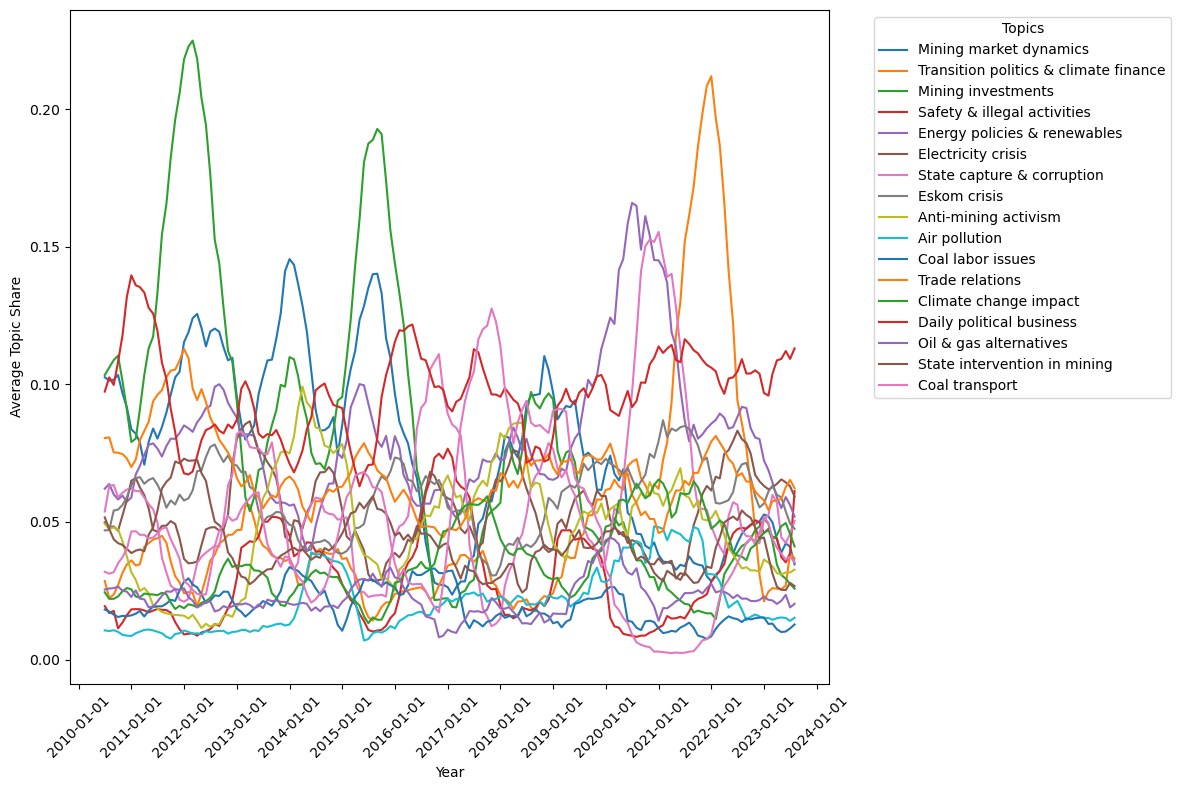

Calculating topic co-occurrence matrix...


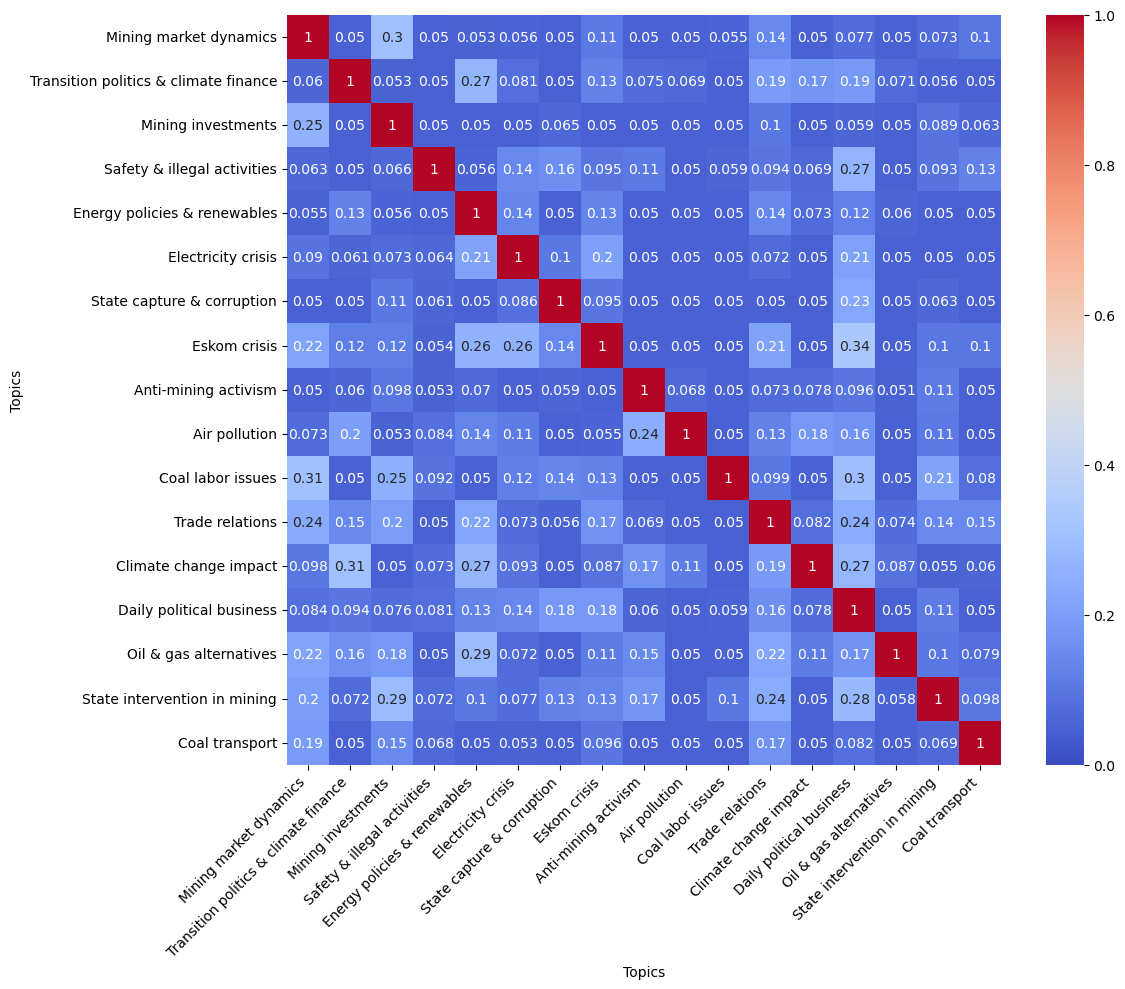

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

# Load your model from disk
print("Loading model from disk...")
with open('dtm_model_subset_100_percent.pkl', 'rb') as file:
    model = pickle.load(file)
print("Model loaded.")

# Load your preprocessed dataset
print("Loading data...")
df = pd.read_csv('/Users/giacomoraederscheidt/Dropbox/Paper_Giacomo_Lotti/0 Data/coal_data_preprocessed.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Prepare timestamps for monthly time slices
print("Preparing time slices...")
df['YearMonth'] = df['Date'].dt.to_period('M')
timestamps = df['YearMonth'].dt.strftime('%Y-%m').unique().tolist()
time_slices = [df['YearMonth'].value_counts()[period] for period in sorted(df['YearMonth'].unique())]

num_topics = 20
topic_shares_over_time = np.zeros((len(time_slices), num_topics))

# Define topic classifications
topic_names = {
    0:  "Mining market dynamics",                
    1:  "Transition politics & climate finance", 
    2:  "Mining investments",                    
    3:  "Safety & illegal activities",           
    4:  "Energy policies & renewables",          
    5:  "Electricity crisis",                    
    6:  "Stopwords/False Positives 1",           # Don't Display
    7:  "State capture & corruption",            
    8:  "Eskom crisis",                          
    9:  "Anti-mining activism",                  
    10: "Indian South Africans history",         # Don't Display
    11: "Air pollution",                         
    12: "Coal labor issues",                     
    13: "Trade relations",                       
    14: "Climate change impact",                 
    15: "Daily political business",              
    16: "Stopwords/False Positives 2",           # Don't Display
    17: "Oil & gas alternatives",                
    18: "State intervention in mining",          
    19: "Coal transport"                         
}

# Topics to exclude by name
exclude_topics = [
    "Stopwords/False Positives 1",
    "Indian South Africans history",
    "Stopwords/False Positives 2"
]

# Filter out topics that should not be displayed
topics_to_display = {k: v for k, v in topic_names.items() if v not in exclude_topics}
filtered_topic_indices = list(topics_to_display.keys())

# Calculate the average topic distribution over time
current_document = 0
for time_slice_index, num_docs in enumerate(time_slices):
    for _ in range(num_docs):
        topic_shares_over_time[time_slice_index, :] += model.gamma_[current_document, :]
        current_document += 1
    topic_shares_over_time[time_slice_index, :] /= num_docs

# Generate date range from January 2010 to October 2023
dates = pd.date_range(start='2010-01-01', periods=len(time_slices), freq='MS')

# Plotting each topic's development over time with rolling average
plt.figure(figsize=(12, 8))
for topic_idx in filtered_topic_indices:
    rolling_avg = pd.Series(topic_shares_over_time[:, topic_idx]).rolling(window=12, center=True).mean()
    plt.plot(dates, rolling_avg, label=topics_to_display[topic_idx])

#plt.title('Topic Shares Over Time (Rolling Average)')
plt.xlabel('Year')
plt.ylabel('Average Topic Share')
plt.xticks(pd.date_range(start=dates[0], end=dates[-1], freq='YS'), rotation=45)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate the co-occurrence matrix
print("Calculating topic co-occurrence matrix...")
co_occurrence_matrix = np.zeros((num_topics, num_topics))
for doc_topics in model.gamma_:
    for i in range(num_topics):
        for j in range(i, num_topics):
            co_occurrence_matrix[i, j] += doc_topics[i] * doc_topics[j]
            if i != j:
                co_occurrence_matrix[j, i] += doc_topics[i] * doc_topics[j]

# Filter the co-occurrence matrix to exclude the topics not to be displayed
filtered_co_occurrence_matrix = co_occurrence_matrix[np.ix_(filtered_topic_indices, filtered_topic_indices)]

# Re-normalize the filtered co-occurrence matrix
for i in range(len(filtered_topic_indices)):
    filtered_co_occurrence_matrix[i, :] /= filtered_co_occurrence_matrix[i, i]

# Adjust values to make low values more distinguishable
min_value = 0.05  # Minimum threshold to differentiate low values
filtered_co_occurrence_matrix[filtered_co_occurrence_matrix < min_value] = min_value

# Plot the co-occurrence matrix as a heatmap with a more suitable color map
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_co_occurrence_matrix, annot=True, xticklabels=list(topics_to_display.values()), yticklabels=list(topics_to_display.values()), cmap='coolwarm', vmin=0, vmax=1)
#plt.title('Topic Co-occurrence Matrix')
plt.xlabel('Topics')
plt.ylabel('Topics')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
